In [2]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('./src/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
import torch
from torch.nn import functional as F
import ot
from matplotlib import pyplot as plt
import seaborn as sns

from csbm.data import Prior

# Implementation of D-IMF iteration

In [386]:
def plot_coupling(coupling: torch.Tensor):
    plt.figure(figsize=(10, 8))
    sns.heatmap(coupling.numpy(), cmap='viridis', annot=True, fmt='0.2f')
    plt.title('Estimated Coupling Matrix Heatmap')
    plt.xlabel('Categories')
    plt.ylabel('Categories') 
    plt.show()

def bridge_probability(
    prior: Prior, t_n: int, nominator: bool = False
) -> torch.Tensor:
    """returns probability of shape [n, n, n] if nominator is False, and [n, n, n, n] if nominator is True,
    where first two dimensions correspont to x_0 and x_1, and last two dimensions correspont to x_tnp1 and x_1
    """
    # Define meshgrid
    x_0 = torch.arange(prior.num_categories)
    x_tnp1 = torch.arange(prior.num_categories)
    x_1 = torch.arange(prior.num_categories)
    if nominator:
        x_0, x_1, x_tnp1 = torch.meshgrid(x_0, x_1, x_tnp1)
        x_0, x_1, x_tnp1 = x_0.flatten(), x_1.flatten(), x_tnp1.flatten()
    else:
        x_0, x_1 = torch.meshgrid(x_0, x_1)
        x_0, x_1 = x_0.flatten(), x_1.flatten()

    # Define time indices   
    t_0 = torch.tensor(0).expand(x_0.shape[0], 1)
    t_np1 = torch.tensor(t_n + 1).expand(x_0.shape[0], 1)
    t_n = torch.tensor(t_n).expand(x_0.shape[0], 1)
    t_1 = torch.tensor(prior.num_timesteps + 1).expand(x_0.shape[0], 1)

    if nominator:
        factor1 = prior.extract('cumulative', t_n - t_0, row_id=x_0)
        factor2 = prior.extract('cumulative', t_np1 - t_n, column_id=x_tnp1)
        factor3 = prior.extract('cumulative', t_1 - t_np1, row_id=x_tnp1, column_id=x_1)
        log_probs = torch.log(factor1 + prior.eps) + torch.log(factor2 + prior.eps) + torch.log(factor3 + prior.eps)
    else:
        factor1 = prior.extract('cumulative', t_n - t_0, row_id=x_0)
        factor2 = prior.extract('cumulative', t_1 - t_n, column_id=x_1)
        log_probs = torch.log(factor1 + prior.eps) + torch.log(factor2 + prior.eps)

    sub_denom = prior.extract('cumulative', t_1, row_id=x_0, column_id=x_1)
    log_probs = log_probs - torch.log(sub_denom + prior.eps)
    probs = torch.exp(log_probs)
    if nominator:
        return probs.reshape(*[prior.num_categories] * 4)
    else:
        return probs.reshape(*[prior.num_categories] * 3)

# Input

In [391]:
alpha = 0.1
dim = 1
num_categories = 16
num_timesteps = 8
prior_type = 'uniform'
num_imf_iterations = 20

p_0 = torch.full((num_categories,), 1 / num_categories, dtype=torch.float64)
p_1 = torch.arange(num_categories, dtype=torch.float64) / torch.sum(torch.arange(num_categories, dtype=torch.float64))
prior = Prior(
    alpha=alpha,
    num_categories=num_categories ** dim,
    num_timesteps=num_timesteps,
    num_skip_steps=1,
    prior_type=prior_type
)

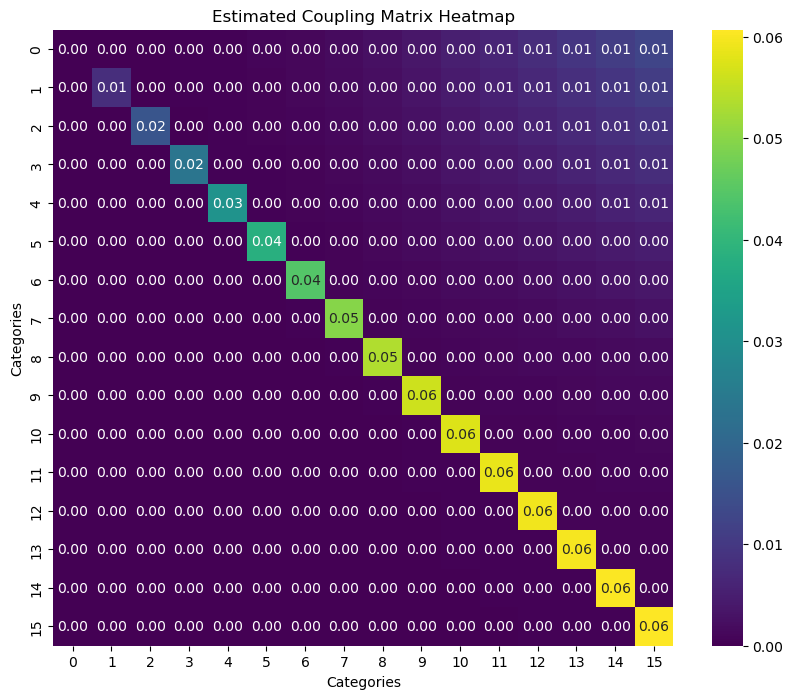

In [392]:
true_coupling = ot.sinkhorn(p_0, p_1, -torch.log(prior.p_onestep[1].transpose(0, 1)), reg=1.0)
plot_coupling(true_coupling)

/trinity/home/g.ksenofontov/anaconda3/envs/csbm/lib/python3.12/site-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


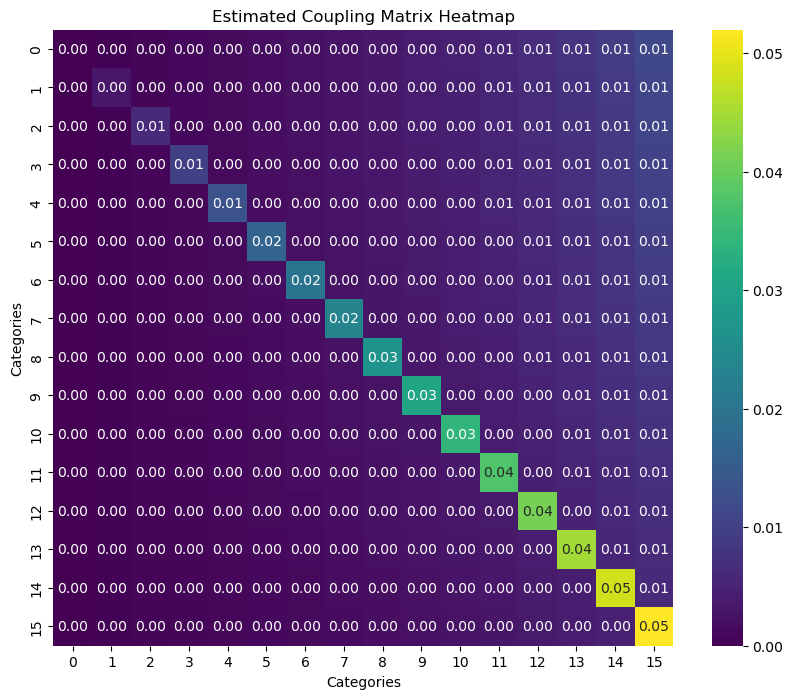

In [397]:
kl_divs = []

coupling = p_0.unsqueeze(1) * p_1.unsqueeze(0)
kl = F.kl_div(torch.log(coupling + prior.eps), torch.log(true_coupling + prior.eps), log_target=True, reduction='mean')
kl_divs.append(kl.item())

for iteration in range(num_imf_iterations):
    transition_probabilities = torch.eye(num_categories, dtype=torch.float64)
    for t_n in range(0, num_timesteps + 1):
        nominator = bridge_probability(prior, t_n=t_n, nominator=True)
        nominator = nominator * coupling.unsqueeze(-1).unsqueeze(-1)
        nominator = nominator.sum(dim=[0, 1])
        
        denominator = bridge_probability(prior, t_n=t_n, nominator=False)
        denominator = denominator * coupling.unsqueeze(-1)
        denominator = denominator.sum(dim=[0, 1])
        transition_probabilities @= (nominator / denominator.unsqueeze(0)) 
    coupling = transition_probabilities * p_0.unsqueeze(1)
    
    transition_probabilities = torch.eye(num_categories, dtype=torch.float64)
    for t_n in range(1, num_timesteps + 2):
        nominator = bridge_probability(prior, t_n=t_n, nominator=True)
        nominator = nominator * coupling.unsqueeze(-1).unsqueeze(-1)
        nominator = nominator.sum(dim=[0, 1])
        
        denominator = bridge_probability(prior, t_n=t_n, nominator=False)
        denominator = denominator * coupling.unsqueeze(-1)
        denominator = denominator.sum(dim=[0, 1])
        transition_probabilities @= (nominator / denominator.unsqueeze(0)) 
    coupling = transition_probabilities * p_1.unsqueeze(0)

    kl = F.kl_div(torch.log(coupling + prior.eps), torch.log(true_coupling + prior.eps), log_target=True, reduction='mean')
    kl_divs.append(kl.item())
plot_coupling(coupling)

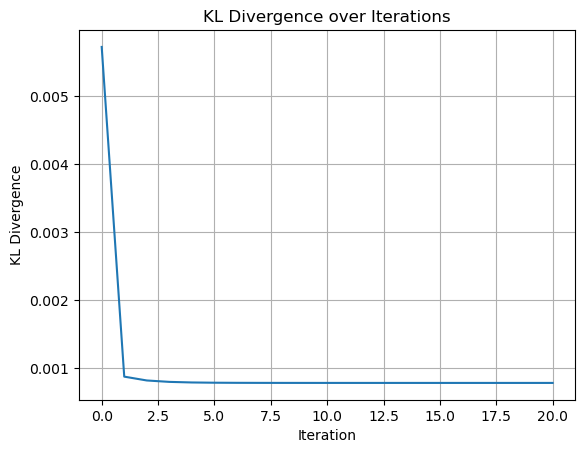

In [398]:
sns.lineplot(x=range(len(kl_divs)), y=kl_divs)  # Explicitly set x values to the iteration range
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Iterations')
plt.grid(True)  # Add grid for better readability
plt.show()